**IEM Closure of $f_B$ in 1D**

Following [Pope et al. 1985](https://www.sciencedirect.com/science/article/abs/pii/0360128585900024) the evolution equation for these distributions is given by

\begin{equation}
\frac{\partial f_B}{\partial t} = -\frac{\partial }{\partial b} \left( \mathbb{E}_B[ \alpha \nabla^2 B ] f_B \right).
\end{equation}

which can be written as the SDE

\begin{equation}
dB_t = \mathbb{E}_B[ \alpha \nabla^2 B ] dt.
\end{equation}


As $f_B(b,t)$ contains no information about space this equation is unclosed as the conditional expectation is unknown, however we can apply the IEM closure developed by (Dopazo, C. & O'Brien, E. 1974) and discussed by (Pope, S.B. 2010) to estimate a closure for the molecular mixing terms. This closure takes the form

\begin{equation}
    \mathbb{E}_B[ \alpha \nabla^2 B ] = - \omega_B  \left( b - \mathbb{E}[B] \right),
\end{equation}

where $\omega_B$ is the dissipation frequency that must be modelled. Substituting in for this closure we obtain 

\begin{equation}
\frac{\partial f_B}{\partial t} =  \frac{\partial }{\partial b} \left( \omega_B \left( b - \mathbb{E}[B] \right) f_B \right).
\end{equation}

or 

\begin{equation}
dB_t = - \omega_B \left( B_t - \mathbb{E}[B] \right) dt.
\end{equation}

Integration of this equation with respect to $b$ shows that it conserves $f_B$. As noted by (Fox, R.O. 2003) the IEM closure does not relax to a Gaussian at large times and in particular for an initial condition consisting of two dirac measures at $b = \pm 1$ does not evolve the PDF at all as $\mathbb{E}[B] = 0$ and therefore the system remains at $f_B(b,t=0)$. To rectify this issue to follow (Valiano, L. & Dopazo, C. 1991) by adding a "bounded" noise to the buoyancy yielding 

\begin{equation}
\frac{\partial f_B}{\partial t} =  \frac{\partial }{\partial b} \left( \omega_B \left( b - \mathbb{E}[B] \right) f_B \right) + \frac{\sigma^2}{2} \frac{\partial^2 f_B}{\partial b^2},
\end{equation}

or 

\begin{equation}
dB_t = - \omega_B \left( B_t - \mathbb{E}[B] \right) dt + \sigma dW_t
\end{equation}


where $\Gamma$ must be modelled. 

To implement Neumann boundary conditions 

\begin{equation}
\frac{\partial f_B}{\partial b} \bigg|_{B = b_{min},b_{max}} = 0, 
\end{equation}

at the ends of the domain in terms of the Monte-Carlo method we can use reflective boundary coditions

\begin{align}
B_t &= b_{max} - (B_t - b_{max}), \\
B_t &= b_{min} + (b_{min} - B_t),
\end{align}

An alternative possibility is to impose Dirichlet boundary conditions

\begin{equation}
f_B |_{B = b_{min},b_{max}} = 0, 
\end{equation}

which for a Monte-Carlo simulation is equivalent to removing particles i.e. if $B_t$ reaches $b_{min}$ or $b_{max}$ remove this particle. This boundary condition is often called an absorbing boundary condition.

We implement the mixing of the initial condition $B(\mathbf{x},t=0)$ consisting of blobs of fluid at $b = \pm 1$. Note that as the evolution of $f_B$ depends on what is happening everywhere in the domain the system is both non-linear and non-local. Our choice of closure therefore results in a McKean-Vlasov equation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm

# Parameters
num_particles = 10**4  # Number of Monte Carlo samples
num_steps = 1000      # Time steps
dt = 0.01               # Time step size
sigma = .1             # Diffusion coefficient
omega_b = 1.0

b_min =-1.1
b_max = 1.1

# Brownian increments
dW_t = np.sqrt(dt) * norm.rvs(loc=0, scale=1, size=(num_particles, num_steps))  

# Container
b = np.zeros((num_particles, num_steps))

# Initial conditions, half of the particles to +1 and the other to -1
b[:num_particles//2,0] = 1
b[num_particles//2:,0] =-1

plt.hist(b[:, 0], bins=50, density=True, alpha=0.6, label="Monte Carlo Histogram")
plt.xlim([-1.1, 1.1])
plt.show()

# Euler Maruyama
for n in range(1, num_steps):

    if n%(num_steps // 10) == 0:
        plt.hist(b[:, n-1], bins=50, density=True, alpha=0.6, label="Monte Carlo Histogram")
        plt.xlim([-1.1, 1.1])
        plt.show()

    # Update particles
    E_B     = np.mean(b[:, n-1])
    b[:, n] = b[:, n-1] - omega_b*(b[:, n-1] - E_B) * dt   +    sigma * dW_t[:,n-1]

    # Apply Reflecting/bcs
    b[:, n] = np.where(b[:, n] > b_max, b_max - (b[:, n] - b_max), b[:, n]) # Reflect back inside
    b[:, n] = np.where(b[:, n] < b_min, b_min + (b_min - b[:, n]), b[:, n]) # Reflect back inside


# Estimate the probability density function at final time step using KDE
b_values = np.linspace(-1.2, 1.2, 100)
kde = gaussian_kde(b[:, -1])
pdf_values = kde(b_values)

# Plot the Monte Carlo histogram and estimated density
# plt.figure(figsize=(8, 5))
# plt.hist(b[:, -1], bins=50, density=True, alpha=0.6, label="Monte Carlo Histogram")
# plt.plot(b_values, pdf_values, 'r-', label="Kernel Density Estimation (KDE)")
# plt.xlabel("x")
# plt.ylabel("Probability Density")
# plt.title("Monte Carlo Solution of Fokker-Planck")
# plt.legend()
# plt.show()

We now consider the same system but with a forcing term $\boldsymbol{D}^{(1)}$ which accounts for the sources/sinks to $f_{B}$ via diffusion at the boundaries making

\begin{equation}
\frac{\partial f_B}{\partial t} =  - \frac{\partial }{\partial b} \boldsymbol{D}^{(1)} f_B + \frac{\partial }{\partial b} \left( \frac{\omega_B}{2} \left( b - \mathbb{E}[B] \right) f_B \right) + \frac{\sigma^2}{2} \frac{\partial^2 f_B}{\partial b^2},
\end{equation}

or 

\begin{equation}
dB_t = \boldsymbol{D}^{(1)}(B_t,t) dt - \omega_B \left( B_t - \mathbb{E}[B] \right) dt + \sigma dW_t
\end{equation}

where $\omega_B, \Gamma$ must again be modelled. Integrating this equation with respect to $b$ shows that probability density is conserved provided that $f_B(b) \to 0, \, b \to \pm \infty$. Numerically we choose a sufficiently large domain and impose Neumann boundary conditions. Choosing a forcing $\boldsymbol{D}^{(1)} = -B_t + B_t^3 $ which corresponds to a bimodal potential $ (B^2_t - a^2)^2 $ at $x = \pm a$.

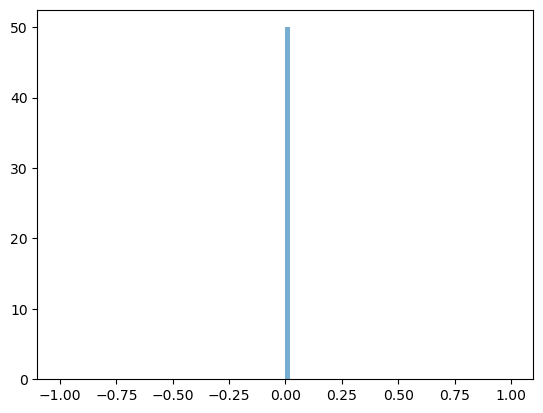

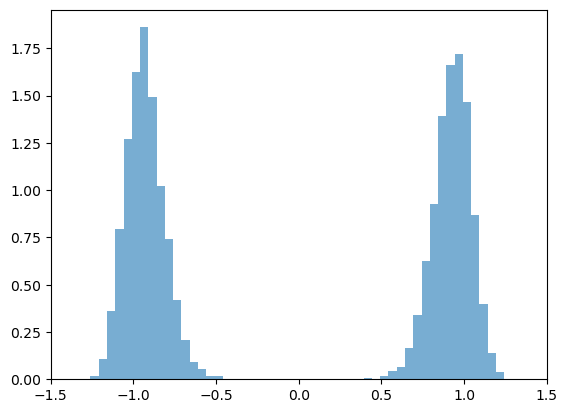

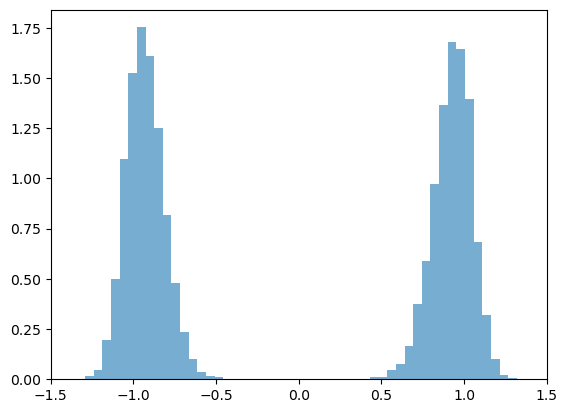

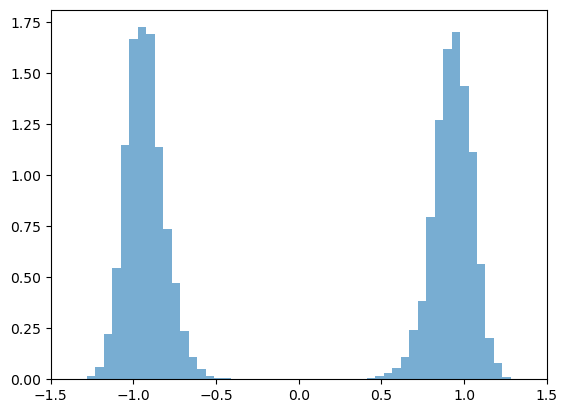

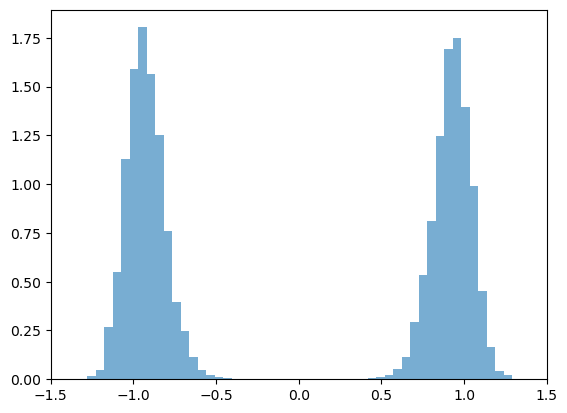

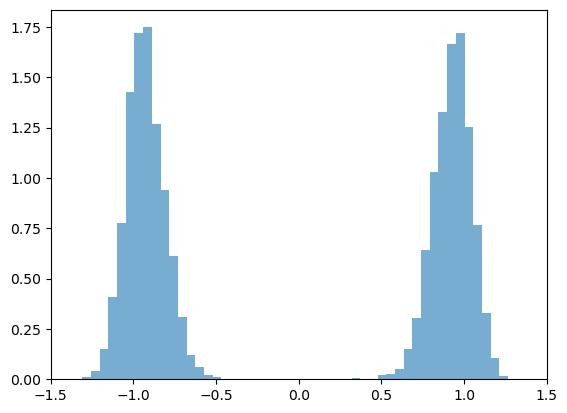

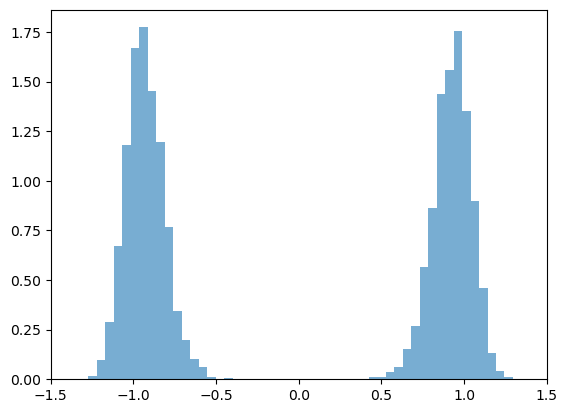

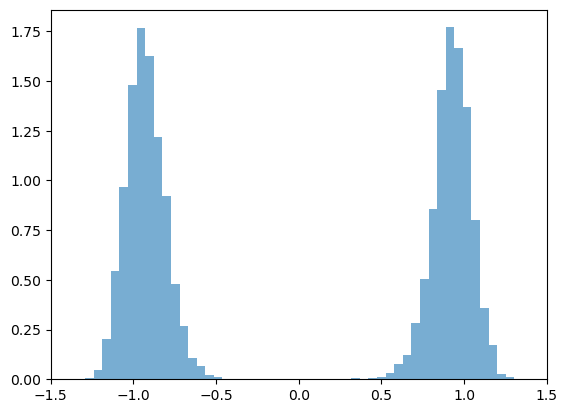

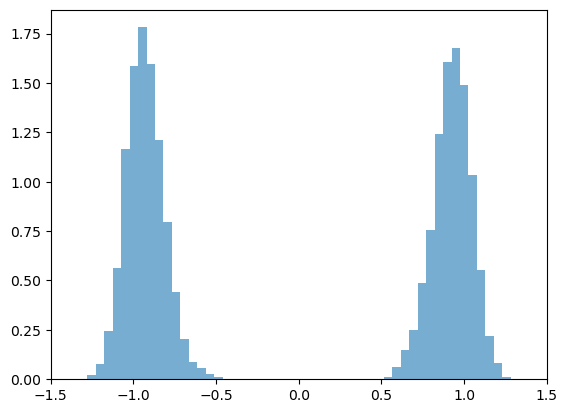

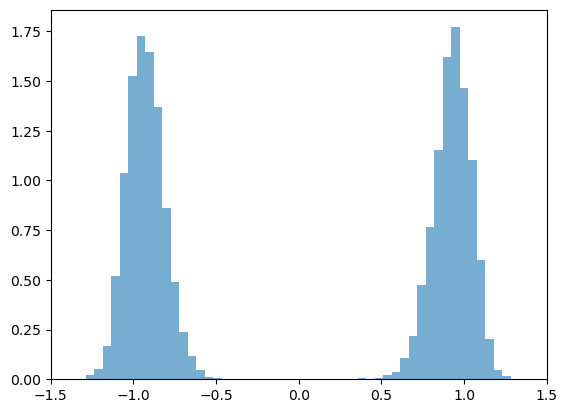

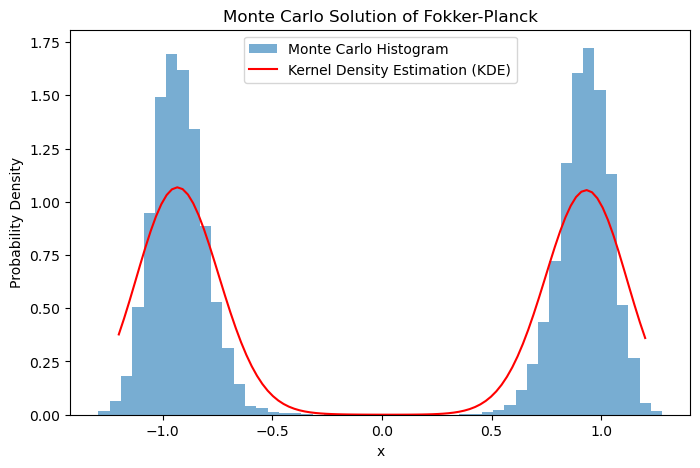

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm

# Parameters
num_particles = 10**4  # Number of Monte Carlo samples
num_steps = 2000      # Time steps
dt = 0.1               # Time step size
sigma = .2             # Diffusion coefficient
omega_b = 0.1

b_min =-1.5
b_max = 1.5

# Brownian increments
dW_t = np.sqrt(dt) * norm.rvs(loc=0, scale=1, size=(num_particles, num_steps))  

# Container
b = np.zeros((num_particles, num_steps))

# Initial conditions, half of the particles to +1 and the other to -1
b[:num_particles//2,0] = 1
b[num_particles//2:,0] =-1

plt.hist(b[:, 0], bins=50, density=True, alpha=0.6, label="Monte Carlo Histogram")
plt.xlim([-1.1, 1.1])
plt.show()

# Euler Maruyama
for n in range(1, num_steps):

    if n%(num_steps // 10) == 0:
        plt.hist(b[:, n-1], bins=50, density=True, alpha=0.6, label="Monte Carlo Histogram")
        plt.xlim([b_min, b_max])
        plt.show()

    # Update particles
    E_B     = np.mean(b[:, n-1])
    b[:, n] = b[:, n-1] + (b[:, n-1] - b[:, n-1]**3) * dt - omega_b*(b[:, n-1] - E_B) * dt   +    sigma * dW_t[:,n-1]

    # Apply Reflecting/bcs
    b[:, n] = np.where(b[:, n] > b_max, b_max - (b[:, n] - b_max), b[:, n]) # Reflect back inside
    b[:, n] = np.where(b[:, n] < b_min, b_min + (b_min - b[:, n]), b[:, n]) # Reflect back inside


# Estimate the probability density function at final time step using KDE
b_values = np.linspace(-1.2, 1.2, 100)
kde = gaussian_kde(b[:, -1])
pdf_values = kde(b_values)

#Plot the Monte Carlo histogram and estimated density
plt.figure(figsize=(8, 5))
plt.hist(b[:, -1], bins=50, density=True, alpha=0.6, label="Monte Carlo Histogram")
plt.plot(b_values, pdf_values, 'r-', label="Kernel Density Estimation (KDE)")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.title("Monte Carlo Solution of Fokker-Planck")
plt.legend()
plt.show()